# Прогнозирование цены BTCUSDT
## Курсовая работа по машинному обучению

# Введение

* Цель — прогноз цены BTC/USDT с помощью ML
* Задача актуальна в трейдинге и аналитике
* Крипта — сложный и волатильный рынок


## Источники данных

* Источник — биржа ByBit
* Данные: дневные свечи за полгода и почасовые за год
* Поля: open, high, low, close, volume, turnover, open_interest


## Модель RandomForest

* Начал с RandomForestRegressor
* Признаки: цены, скользящие средние, волатильность, прирост
* Результаты неплохие, но нет учёта временных зависимостей


In [33]:
pip install pandas requests scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/1838996078.py:26: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


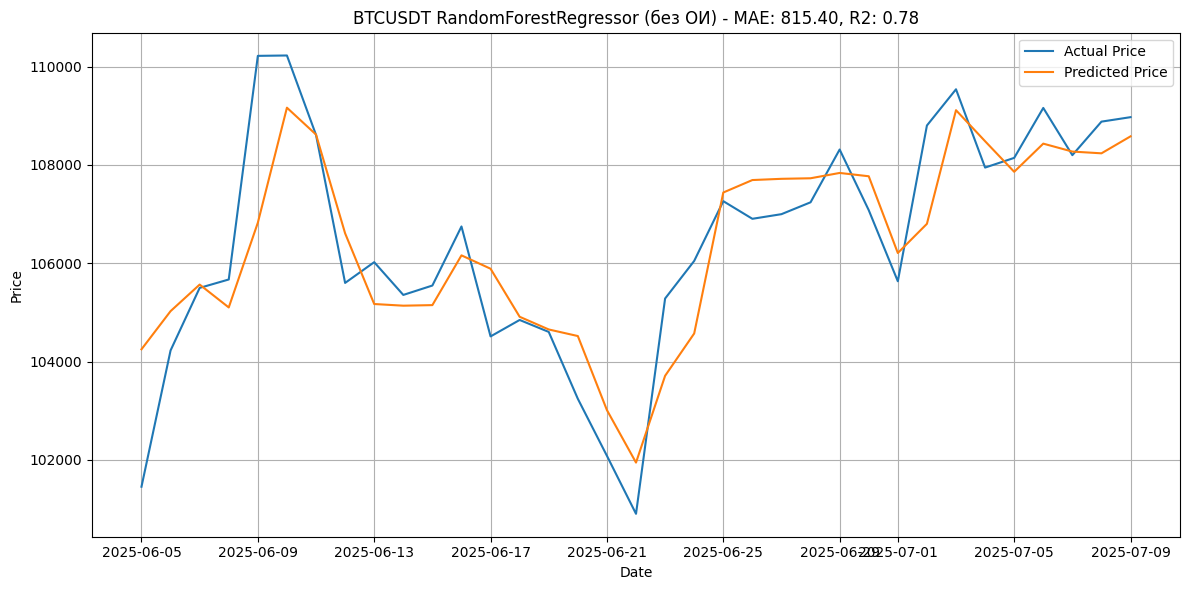

In [34]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Step 1: Fetch data
def fetch_bybit_kline(symbol='BTCUSDT', interval='D', limit=180):
    url = "https://api.bybit.com/v5/market/kline"
    params = {
        'category': 'linear',
        'symbol': symbol,
        'interval': interval,
        'limit': limit
    }
    resp = requests.get(url, params=params)
    data = resp.json()
    candles = data.get('result', {}).get('list', [])
    if not candles:
        raise ValueError("No data from Bybit")
    
    df = pd.DataFrame(candles, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.astype({
        'open': float, 'high': float, 'low': float, 'close': float,
        'volume': float, 'turnover': float
    })
    df = df.sort_values('timestamp')
    return df

# Step 2: Feature engineering
df = fetch_bybit_kline()
df['prev_close'] = df['close'].shift(1)
df['pct_change'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(window=5).mean()
df['sma_10'] = df['close'].rolling(window=10).mean()
df['volatility'] = df['high'] - df['low']
df = df.dropna()

# Step 3: Prepare data for model
features = ['open', 'high', 'low', 'volume', 'turnover', 'prev_close', 'pct_change', 'sma_5', 'sma_10', 'volatility']
target = 'close'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Step 5: Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 6: Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'].iloc[-len(y_test):], y_test.values, label='Actual Price')
plt.plot(df['timestamp'].iloc[-len(y_test):], y_pred, label='Predicted Price')
plt.title(f"BTCUSDT RandomForestRegressor (без ОИ) - MAE: {mae:.2f}, R2: {r2:.2f}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Добавление open interest

* Добавлен признак open_interest
* Анализ важности признаков: важны high, low
* Volume и turnover — слабые


https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=D&limit=180


/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/1884325852.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1d&start=1736524334446&end=1752076334446&limit=180


/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/1884325852.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


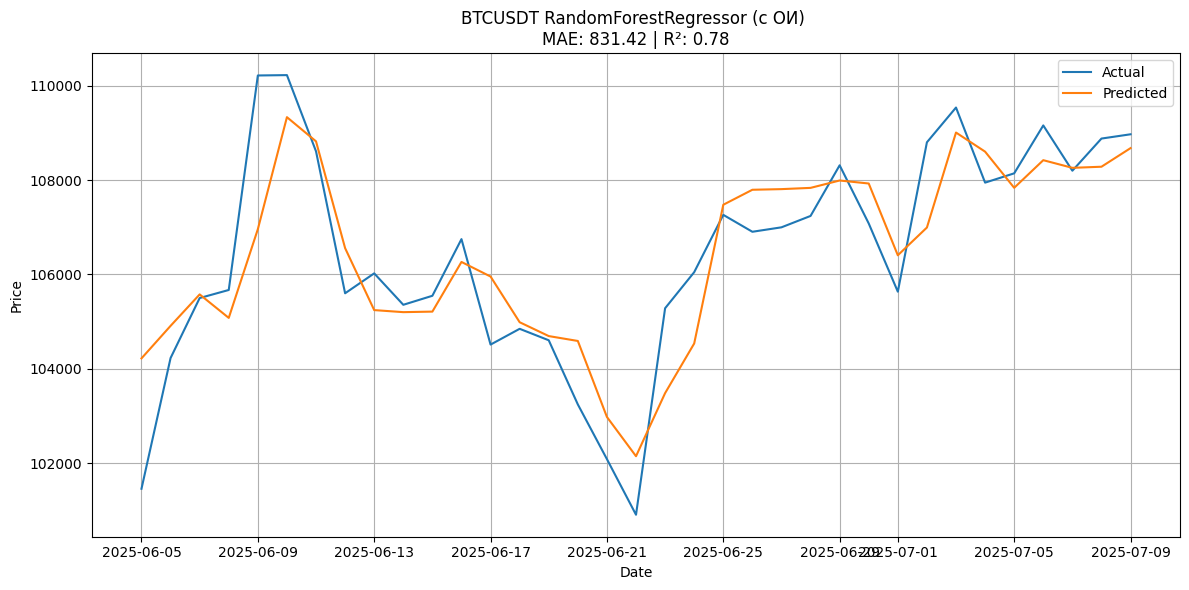

In [35]:
import requests
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time

# Получаем основные параметры 
def fetch_bybit_kline(symbol='BTCUSDT', interval='D', limit=180):
    url = "https://api.bybit.com/v5/market/kline"
    params = {'category': 'linear', 'symbol': symbol, 'interval': interval, 'limit': limit}
    
    print(requests.Request('GET', url, params=params).prepare().url)
    
    resp = requests.get(url, params=params)
    candles = resp.json()['result']['list']
    df = pd.DataFrame(candles, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.astype(float, errors='ignore')
    df = df.sort_values('timestamp')
    return df

# Получаем открытый интерес
def fetch_open_interest(symbol='BTCUSDT', interval='1d', limit=180):
    now = int(time.time() * 1000)
    day_ms = 86400000
    start = now - day_ms * limit

    url = "https://api.bybit.com/v5/market/open-interest"
    params = {
        "category": "linear",
        "symbol": symbol,
        "intervalTime": interval,
        "start": start,
        "end": now,
        "limit": limit
    }

    print(requests.Request('GET', url, params=params).prepare().url)

    resp = requests.get(url, params=params)
    items = resp.json().get('result', {}).get('list', [])

    if not items:
        raise ValueError("No open interest data returned.")

    # Мержим значения по timestamp
    df = pd.DataFrame(items)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open_interest'] = df['openInterest'].astype(float)
    return df[['timestamp', 'open_interest']].sort_values('timestamp')



# Загрузка данных
df_price = fetch_bybit_kline()
df_oi = fetch_open_interest()
df = pd.merge(df_price, df_oi, on='timestamp')

# Создаем дополнительные факторы
df['prev_close'] = df['close'].shift(1)
df['pct_change'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_10'] = df['close'].rolling(10).mean()
df['volatility'] = df['high'] - df['low']
df = df.dropna()

# Модель
features = ['open', 'high', 'low', 'volume', 'turnover', 'prev_close', 'pct_change', 'sma_5', 'sma_10', 'volatility', 'open_interest']
X = df[features]
y = df['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'].iloc[-len(y_test):], y_test.values, label='Actual')
plt.plot(df['timestamp'].iloc[-len(y_test):], y_pred, label='Predicted')
plt.title(f'BTCUSDT RandomForestRegressor (с ОИ) \nMAE: {mae:.2f} | R²: {r2:.2f}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


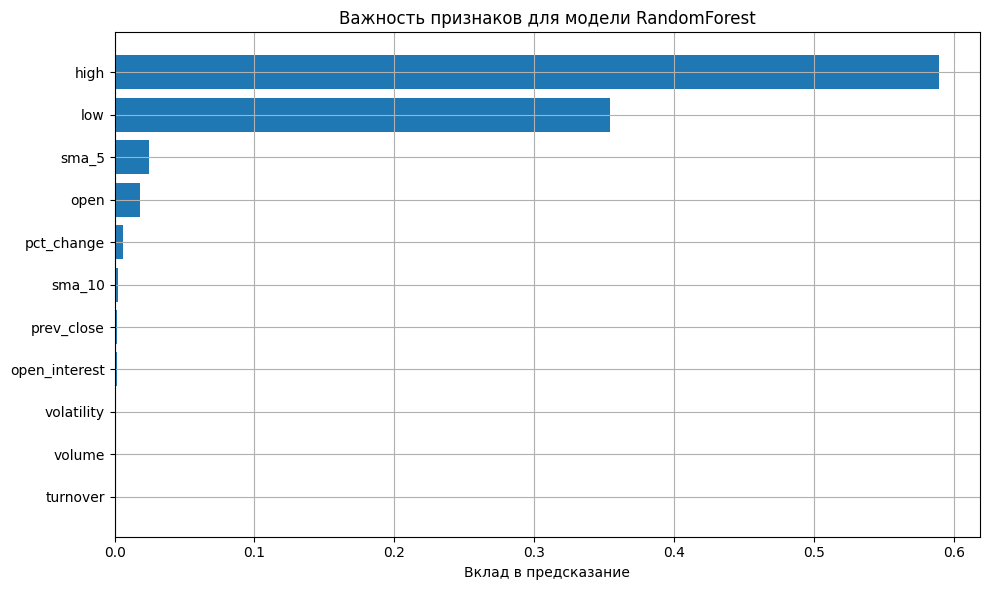

In [36]:
# Анализ важности признаков
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.title('Важность признаков для модели RandomForest')
plt.xlabel('Вклад в предсказание')
plt.grid(True)
plt.tight_layout()
plt.show()


## Переход к LSTM

* LSTM — модель для временных рядов
* Первые тесты на дневных свечах провалились
* Причина — мало данных


In [37]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/876276448.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


Epoch 1/30


/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/876276448.py:49: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
/Users/alt3rmann/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0705  
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114 
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0065 
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079 
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

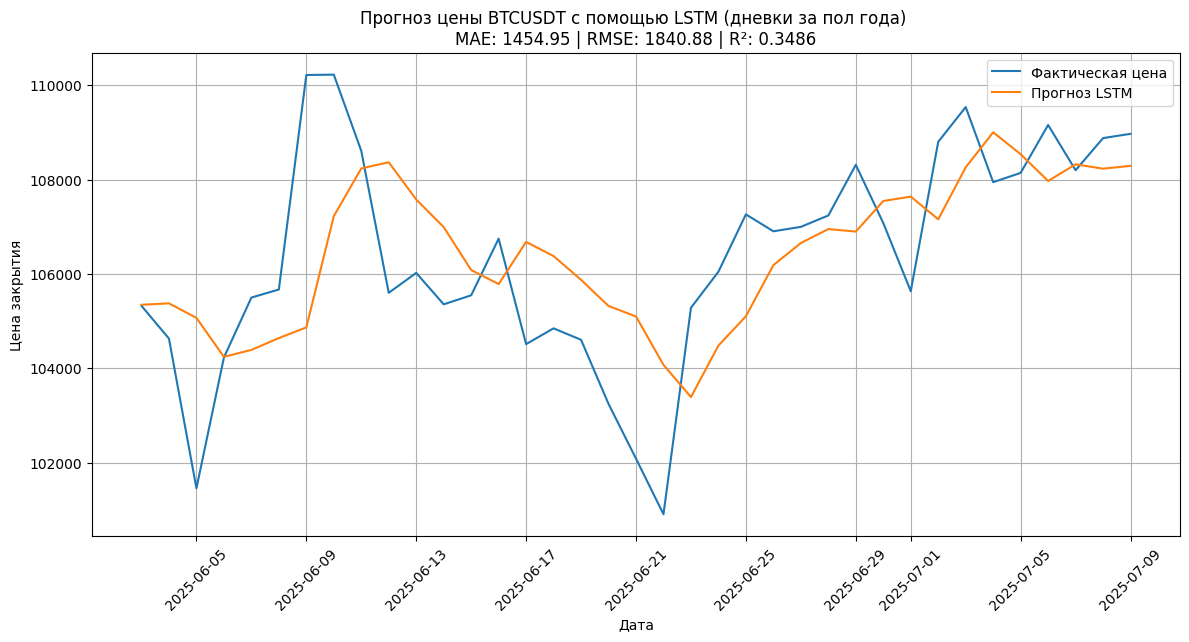

In [38]:

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Получение исторических данных по свечам с биржи Bybit
def fetch_bybit_kline(symbol='BTCUSDT', interval='D', limit=200):
    url = "https://api.bybit.com/v5/market/kline"
    params = {'category': 'linear', 'symbol': symbol, 'interval': interval, 'limit': limit}
    resp = requests.get(url, params=params)
    candles = resp.json()['result']['list']
    df = pd.DataFrame(candles, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.astype(float, errors='ignore')
    df = df.sort_values('timestamp')
    return df

# Получение данных по открытому интересу
def fetch_open_interest(symbol='BTCUSDT', interval='1d', limit=200):
    now = int(time.time() * 1000)
    day_ms = 86400000
    start = now - day_ms * limit

    url = "https://api.bybit.com/v5/market/open-interest"
    params = {
        "category": "linear",
        "symbol": symbol,
        "intervalTime": interval,
        "start": start,
        "end": now,
        "limit": limit
    }

    resp = requests.get(url, params=params)
    items = resp.json().get('result', {}).get('list', [])

    if not items:
        raise ValueError("Нет данных по открытому интересу.")

    df = pd.DataFrame(items)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open_interest'] = df['openInterest'].astype(float)
    return df[['timestamp', 'open_interest']].sort_values('timestamp')

# Загрузка и объединение данных
df_price = fetch_bybit_kline()
df_oi = fetch_open_interest()
df = pd.merge(df_price, df_oi, on='timestamp')

# Генерация дополнительных признаков
df['prev_close'] = df['close'].shift(1)
df['pct_change'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_10'] = df['close'].rolling(10).mean()
df['volatility'] = df['high'] - df['low']
df = df.dropna()

# Список признаков, которые будут использоваться для обучения модели
features = ['open', 'high', 'low', 'volume', 'turnover', 'prev_close',
            'pct_change', 'sma_5', 'sma_10', 'volatility', 'open_interest']

# Масштабируем данные с помощью MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + ['close']])

# Функция генерации обучающих и тестовых выборок с окнами
def create_dataset(data, window_size=10):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, :-1])  # все признаки, кроме 'close'
        y.append(data[i, -1])  # целевая переменная — 'close'
    return np.array(X), np.array(y)

# Создаем выборки
window_size = 10
X, y = create_dataset(scaled_data, window_size=window_size)

# Делим данные на train и test (80/20)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Создаем модель LSTM
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # выходной слой — предсказание close
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

# Предсказываем значения
y_pred = model.predict(X_test)

# Обратное преобразование предсказаний и фактических значений
scaled_close = scaled_data[window_size:, -1]

real_close = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_test), scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)), axis=1)
)[:, -1]

pred_close = scaler.inverse_transform(
    np.concatenate((np.zeros((len(y_pred), scaled_data.shape[1] - 1)), y_pred), axis=1)
)[:, -1]

# Вычисляем метрики
mae = mean_absolute_error(real_close, pred_close)
rmse = np.sqrt(mean_squared_error(real_close, pred_close))
r2 = r2_score(real_close, pred_close)

# Визуализация результатов
import matplotlib.dates as mdates
dates = df['timestamp'].iloc[window_size + split_index:]

plt.figure(figsize=(12, 6))
plt.plot(dates, real_close, label='Фактическая цена')
plt.plot(dates, pred_close, label='Прогноз LSTM')
plt.title(f'Прогноз цены BTCUSDT с помощью LSTM (дневки за пол года) \nMAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## Улучшение модели

* Использованы часовые данные за год
* Окно — 48 (2 суток), 30 эпох
* Масштабирование признаков


In [39]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

# === Общие параметры ===
symbol = 'BTCUSDT'
interval_kline = '60'  # 60 минут
interval_oi = '1h'     # 1 час
limit_kline = 1000     # максимум для свечей
limit_oi = 200         # максимум для OI

# Период за последний год
now_ms = int(time.time() * 1000)
one_year_ago_ms = now_ms - (365 * 24 * 60 * 60 * 1000)

# === Получение свечей ===
def fetch_all_klines():
    print("Загружаем свечи...")
    url = "https://api.bybit.com/v5/market/kline"
    all_data = []
    start = one_year_ago_ms
    now = int(time.time() * 1000)

    while start < now:
        end = min(start + limit_kline * 60 * 60 * 1000, now)

        params = {
            'category': 'linear',
            'symbol': symbol,
            'interval': interval_kline,
            'start': start,
            'end': end,
            'limit': limit_kline
        }

        # DEBUG: выводим реальный запрос
        print(requests.Request('GET', url, params=params).prepare().url)

        resp = requests.get(url, params=params)
        data = resp.json().get('result', {}).get('list', [])

        if not data:
            print("Нет новых данных. Завершаем.")
            break

        all_data.extend(data)

        last_ts = int(data[0][0])
        if last_ts <= start:
            print("Повторяющийся timestamp. Завершаем.")
            break

        start = last_ts + 1
        time.sleep(0.05)

    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.astype(float, errors='ignore')
    
    print (df)
    
    return df.sort_values('timestamp')



# === Получение open interest ===
def fetch_all_open_interest():
    url = "https://api.bybit.com/v5/market/open-interest"
    all_data = []
    start = one_year_ago_ms

    while start < int(time.time() * 1000):
        end = min(start + limit_oi * 60 * 60 * 1000, int(time.time() * 1000))

        params = {
            'category': 'linear',
            'symbol': symbol,
            'intervalTime': interval_oi,
            'startTime': start,
            'endTime': end,
            'limit': limit_oi
        }

        print(requests.Request('GET', url, params=params).prepare().url)
        
        resp = requests.get(url, params=params).json()
        data = resp.get('result', {}).get('list', [])

        if not data:
            break

        all_data.extend(data)

        if len(data) < limit_oi:
            break

        last_ts = int(data[0]['timestamp'])
        if last_ts <= start:
            break  # защита от зацикливания

        start = last_ts + 1
        time.sleep(0.05)

    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['open_interest'] = df['openInterest'].astype(float)
    
    print (df)
    
    return df[['timestamp', 'open_interest']].sort_values('timestamp')


# === Запуск ===
print("Загружаем свечи...")
df_price = fetch_all_klines()

print("Загружаем open interest...")
df_oi = fetch_all_open_interest()

# Объединение по timestamp
df = pd.merge(df_price, df_oi, on='timestamp', how='inner')
print(f"Получено строк после объединения: {len(df)}")

print(df)


Загружаем свечи...
Загружаем свечи...
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1720540338679&end=1724140338679&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1724137200001&end=1727737200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1727737200001&end=1731337200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1731337200001&end=1734937200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1734937200001&end=1738537200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1738537200001&end=1742137200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=60&start=1742137200001&end=1745737200001&limit=1000
https://api.bybit.com/v5/market/kline?category=linea

/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/724238366.py:60: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1721257200001&endTime=1721977200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1721977200001&endTime=1722697200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1722697200001&endTime=1723417200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1723417200001&endTime=1724137200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1724137200001&endTime=1724857200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=1724857200001&endTime=1725577200001&limit=200
https://api.bybit.com/v5/market/open-interest?category=linear&symbol=BTCUSDT&intervalTime=1h&startTime=172

/var/folders/4b/pq7jt81n19j211wncdl7mgfh0000gn/T/ipykernel_51076/724238366.py:108: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


In [40]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Результаты LSTM

MAE ≈ 270, R² ≈ 0.99
Хорошее попадание в поведение цены
Прогнозируются даже экстремумы


Epoch 1/30


/Users/alt3rmann/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0723
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.4057e-04
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.1550e-04
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7131e-04
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6336e-04
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3928e-04
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2182e-04
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9241e-04
Epoch 9/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7683e-04
Epoch 10/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6666e-04
Epoch 11/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3366e-04
Epoch 12/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2174e-04
Epoch 13/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0744e-04
Epoch 14/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9956e-05
Ep

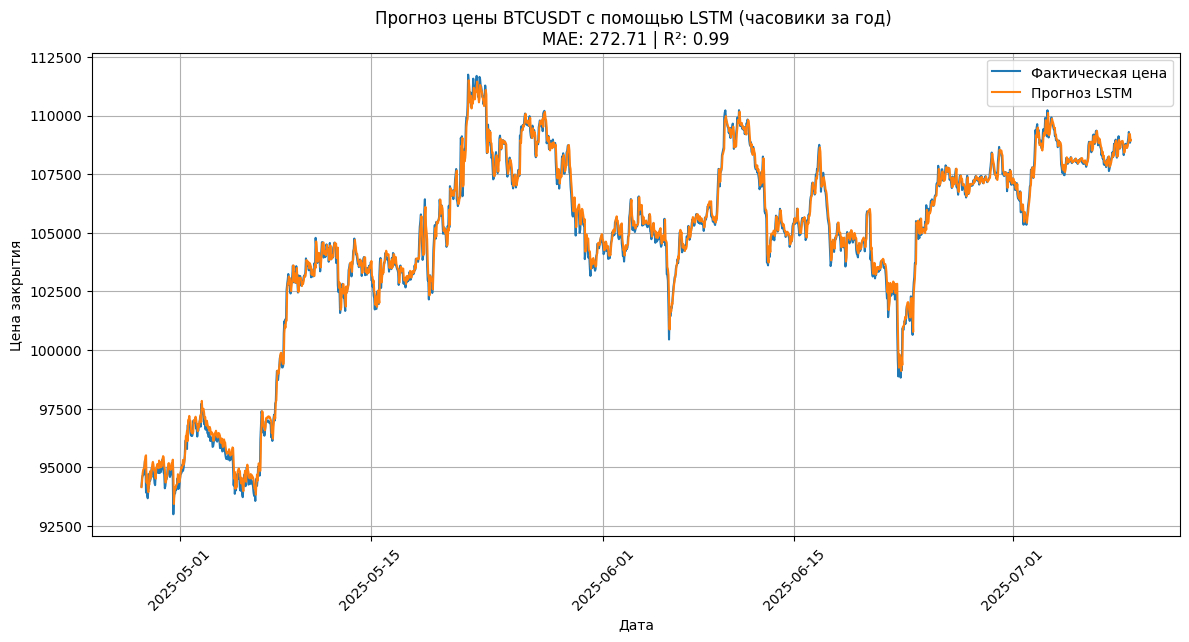

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import time

# === Добавляем признаки на основе исторических данных ===
# df должен быть уже загружен и содержать колонку 'timestamp'
df['prev_close'] = df['close'].shift(1)  # предыдущее закрытие
df['pct_change'] = df['close'].pct_change()  # процентное изменение
df['sma_5'] = df['close'].rolling(5).mean()  # скользящее среднее за 5
df['sma_10'] = df['close'].rolling(10).mean()  # скользящее среднее за 10
df['volatility'] = df['high'] - df['low']  # внутридневная волатильность
df = df.dropna()  # убираем строки с NaN, образовавшиеся из-за сдвигов

# === Определяем признаки, которые будем использовать для обучения модели ===
features = ['open', 'high', 'low', 'volume', 'turnover', 'prev_close',
            'pct_change', 'sma_5', 'sma_10', 'volatility', 'open_interest']

# === Масштабируем данные в диапазон от 0 до 1 для улучшения сходимости LSTM ===
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features + ['close']])  # 'close' — целевая переменная

# === Генерация обучающих последовательностей (look_back окно) ===
def create_dataset(data, window_size=48):  # 48 часов — 2 дня
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, :-1])  # все признаки кроме 'close'
        y.append(data[i, -1])  # 'close' как целевая переменная
    return np.array(X), np.array(y)

window_size = 48
X, y = create_dataset(scaled_data, window_size=window_size)

# === Делим выборку на обучающую и тестовую (80/20) ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === Построение LSTM модели ===
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),  # один LSTM слой
    Dense(1)  # выходной слой
])
model.compile(optimizer='adam', loss='mse')  # используем среднеквадратичную ошибку
model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=1)

# === Прогнозирование на тестовой выборке ===
y_pred = model.predict(X_test)

# === Обратное масштабирование предсказаний и фактических значений ===
def invert_scale(pred, original, scaler, feature_count):
    full = np.zeros((len(pred), feature_count + 1))
    full[:, -1] = pred.reshape(-1)
    return scaler.inverse_transform(full)[:, -1]

pred_close = invert_scale(y_pred, y_test, scaler, len(features))
real_close = invert_scale(y_test, y_test, scaler, len(features))

# === Расчёт метрик качества прогноза ===
mae = mean_absolute_error(real_close, pred_close)
rmse = np.sqrt(mean_squared_error(real_close, pred_close))
r2 = r2_score(real_close, pred_close)

# === Выводим численные метрики ===
results = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "R²": [r2]
})
print("Метрики качества прогноза LSTM:")
print(results)

# === Построение графика прогноза vs фактическая цена ===
# Восстанавливаем временной ряд для X_test
timestamps = df['timestamp'].iloc[window_size + split:]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, real_close, label='Фактическая цена')
plt.plot(timestamps, pred_close, label='Прогноз LSTM')
plt.title(f'Прогноз цены BTCUSDT с помощью LSTM (часовики за год) \nMAE: {mae:.2f} | R²: {r2:.2f}')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## Выводы

* RandomForest + анализ важности — хорошее начало
* LSTM требует данных, но даёт точный результат
* Подготовка данных — ключевой фактор


## Планы на будущее

* Попробовать BiLSTM, GRU, Transformer
* Добавить новости и индекс страха
* Работа с кросс-активами (ETH, NASDAQ)
* Подключение к стримам и запуск торгового бота
